In [7]:
from os import walk
from os.path import join
from os import stat
import random
import hashlib
import time

mypath = "D:\Download\enron"

file_names = []

# only store files size bigger than 5K
for root, dirs, files in walk(mypath):
    for f in files:
        fullpath = join(root, f)
        if(stat(fullpath).st_size >= 5000):
            file_names.append(fullpath)

In [73]:
upload_files = random.sample(file_names, k = 1000)
check_files = random.choices(file_names, k = 200)

In [74]:
cloud_hash = []
check_hash = []
response_list = {}
dirty_list = []

In [75]:
def upload_file(upload_list, chunk_size):
    for file in upload_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()

        for i in range(0, len(text), chunk_size):
            cloud_hash.append(hashlib.sha256(text[i: i+chunk_size]).hexdigest())
        
def check_file(check_list, chunk_size):
    for file in check_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()
        
        for i in range(0, len(text), chunk_size):
            check_hash.append(hashlib.sha256(text[i: i+chunk_size]).hexdigest())
        
        if len(check_hash) % 2 != 0:
            check_hash.append(random.choice(check_hash))

In [76]:
def set_response_list(percent):
    dirty = random.sample(cloud_hash, k = int(percent * len(cloud_hash)))
    
    for chunk in dirty:
        status = random.randint(1, 2)
        response = random.randint(1, 2)
        if response == 1:
            response_list[chunk].update({status: response})
            if status == 1:
                response_list[chunk].update({2: 2})
            else:
                response_list[chunk].update({1: 2})
        elif random.random() >= 0.5:
            response_list[chunk].update({status: response})
            if status == 1:
                response_list[chunk].update({2: random.randint(1, 2)})
            else:
                response_list[chunk].update({1: random.randint(1, 2)})
        else:
            response_list[chunk].update({status: response})
            if status == 1:
                response_list[chunk].update({2: 0})
            else:
                response_list[chunk].update({1: 0})
                
def set_dirty_list(percent):
    dirty_list = random.sample(cloud_hash, k = int(percent * len(cloud_hash)))

In [77]:
def new():
    query = list(set(check_hash.copy()))
    print("after dedup chunk amount:", len(query))
    upload_amount = 0
    
    flex_e0 = []    # flexible, inexist
    flex_e1 = []    # flexible, exist
    fix_s1_e0 = []    # (1,0) -> 1, (1,1) -> 2
    fix_s1_e1 = []    # (1,0) -> 1, (1,1) -> 2
    fix_s2_e0 = []    # (1,1) -> 1, (1,0) -> 2
    fix_s2_e1 = []    # (1,1) -> 1, (1,0) -> 2
    ran_s1_e0 = []    # (1,0) -> RARE, (1,1) -> 2
    ran_s1_e1 = []    # (1,0) -> RARE, (1,1) -> 2
    ran_s2_e0 = []    # (1,1) -> RARE, (1,0) -> 2
    ran_s2_e1 = []    # (1,1) -> RARE, (1,0) -> 2
    fix_2 = []    # fix, all resposne 2
    
    for chunk in query:
        if chunk not in response_list:
            if chunk in cloud_hash:
                flex_e1.append(chunk)
            else:
                flex_e0.append(chunk)
        else:
            if (1 in response_list[chunk].values()) and (1 in list(response_list[chunk].values())[0]) and (chunk not in cloud_hash):
                fix_s1_e0.append(chunk)
            elif (1 in response_list[chunk].values()) and (1 in list(response_list[chunk].values())[0]) and (chunk in cloud_hash):
                fix_s1_e1.append(chunk)
            elif (1 in response_list[chunk].values()) and (1 in list(response_list[chunk].values())[1]) and (chunk not in cloud_hash):
                fix_s2_e0.append(chunk)
            elif (1 in response_list[chunk].values()) and (1 in list(response_list[chunk].values())[1]) and (chunk in cloud_hash):
                fix_s2_e1.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 in list(response_list[chunk].values())[0]) and (chunk not in cloud_hash):
                ran_s1_e0.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 in list(response_list[chunk].values())[0]) and (chunk in cloud_hash):
                ran_s1_e1.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 in list(response_list[chunk].values())[1]) and (chunk not in cloud_hash):
                ran_s2_e0.append(chunk)
            elif (0 in response_list[chunk].values()) and (0 in list(response_list[chunk].values())[1]) and (chunk in cloud_hash):
                ran_s1_e1.append(chunk)
            else:
                fix_2.append(chunk)
                
    while len(fix_s1_e0) > 0:    # (1,0) -> 1
        if len(fix_s1_e1) > 0:
            fix_s1_e0.pop()
            fix_s1_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e1) > 0:
            fix_s1_e0.pop()
            ran_s1_e1.pop()
            upload_amount += 1
        elif len(flex_e1) > 0:
            fix_s1_e0.pop()
            flex_e1.pop()
            upload_amount += 1
        else:
            break
            
    while len(fix_s1_e1) > 0:
        if len(fix_s1_e0) > 0:
            fix_s1_e1.pop()
            fix_s1_e0.pop()
            upload_amount += 1
        elif len(ran_s1_e0) > 0:
            fix_s1_e1.pop()
            ran_s1_e0.pop()
            upload_amount += 1
        elif len(flex_e0) > 0:
            fix_s1_e1.pop()
            flex_e0.pop()
            upload_amount += 1
        else:
            break
            
    while len(fix_s2_e1) > 0:    # (1,1) -> 1
        if len(fix_s2_e1) >= 2:
            fix_s2_e1.pop()
            fix_s2_e1.pop()
            upload_amount += 1
        elif len(ran_s2_e1) > 0:
            fix_s2_e1.pop()
            ran_s2_e1.pop()
            upload_amount += 1
        elif len(flex_e1) > 0:
            fix_s2_e1.pop()
            flex_e1.pop()
            upload_amount += 1
        else:
            break
        
    while len(ran_s1_e0) > 0:    # (1,0) -> 1 or RARE
        if len(fix_s1_e1) > 0:
            ran_s1_e0.pop()
            fix_s1_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e1) > 0:
            ran_s1_e0.pop()
            ran_s1_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) > 0:
            ran_s1_e0.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(ran_s1_e1) > 0:    # (1,0) -> 1 or RARE
        if len(fix_s1_e0) > 0:
            ran_s1_e1.pop()
            fix_s1_e0.pop()
            upload_amount += 1
        elif len(ran_s1_e0) > 0:
            ran_s1_e1.pop()
            ran_s1_e0.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e0) > 0:
            ran_s1_e1.pop()
            flex_e0.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(ran_s2_e1) > 0:    # (1,1) -> 1 or RARE
        if len(fix_s2_e1) > 0:
            ran_s2_e1.pop()
            fix_s2_e1.pop()
            upload_amount += 1
        elif len(ran_s2_e1) >= 2:
            ran_s2_e1.pop()
            ran_s2_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) > 0:
            ran_s2_e1.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(flex_e0) > 0:    # return 1 or RARE
        if len(fix_s1_e1) > 0:
            flex_e0.pop()
            fix_s1_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e1) > 0:
            flex_e0.pop()
            ran_s1_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) > 0:
            flex_e0.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    while len(flex_e1) > 0:    # return 1 or RARE
        if len(fix_s1_e0) > 0:
            flex_e1.pop()
            fix_s1_e0.pop()
            upload_amount += 1
        elif len(fix_s2_e1) > 0:
            flex_e1.pop()
            fix_s2_e1.pop()
            upload_amount += 1
        elif len(ran_s1_e0) > 0:
            flex_e1.pop()
            ran_s1_e0.pop()
            upload_amount += random.randint(1, 2)
        elif len(ran_s2_e1) > 0:
            flex_e1.pop()
            ran_s2_e1.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e0) > 0:
            flex_e1.pop()
            flex_e0.pop()
            upload_amount += random.randint(1, 2)
        elif len(flex_e1) >= 2:
            flex_e1.pop()
            flex_e1.pop()
            upload_amount += random.randint(1, 2)
        else:
            break
            
    remain_list = flex_e0 + flex_e1 + fix_s1_e0 + fix_s1_e1 + fix_s2_e0 + fix_s2_e1 + ran_s1_e0 + ran_s1_e1 + ran_s2_e0 + ran_s2_e1 + fix_2
    upload_amount += len(remain_list)
    
    return upload_amount

def rare():
    upload_amount = 0
    
    for i in range(0, len(check_hash), 2):
        if (check_hash[i] in dirty_list) or (check_hash[i+1] in dirty_list):
            upload_amount += 2
        elif (check_hash[i] not in cloud_hash) and (check_hash[i+1] not in cloud_hash):
            upload_amount += 2
        else:
            upload_amount += random.randint(1, 2)
    
    return upload_amount

def zeus():
    upload_amount = 0
    
    for i in range(0, len(check_hash), 2):
        if (check_hash[i] in dirty_list) or (check_hash[i+1] in dirty_list):
            upload_amount += 2
        elif (check_hash[i] not in cloud_hash) and (check_hash[i+1] not in cloud_hash):
            upload_amount += 2
        else:
            upload_amount += 1
    
    return upload_amount

def dedup():
    upload_amount = 0
    
    for chunk in check_hash:
        if chunk not in cloud_hash:
            upload_amount += 1
    
    return upload_amount

In [78]:
new_cost = []
rare_cost = []
zeus_cost = []
dedup_cost = []
chunk_amount = []

In [79]:
upload_file(upload_files, 128)
check_file(check_files, 128)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 19086
hash existence amount: 752
after dedup chunk amount: 18800


In [80]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 256)
check_file(check_files, 256)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 9654
hash existence amount: 367
after dedup chunk amount: 9479


In [81]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 512)
check_file(check_files, 512)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 4920
hash existence amount: 169
after dedup chunk amount: 4803


In [82]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 1024)
check_file(check_files, 1024)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 2556
hash existence amount: 68
after dedup chunk amount: 2448


In [83]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 2048)
check_file(check_files, 2048)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 1392
hash existence amount: 28
after dedup chunk amount: 1272


In [84]:
cloud_hash = []
check_hash = []
upload_file(upload_files, 4096)
check_file(check_files, 4096)
chunk_amount.append(len(check_hash))
print("check hash:", len(check_hash))
existence_amount = 0
for h in list(set(check_hash)):
    if h in cloud_hash:
        existence_amount += 1
print("hash existence amount:", existence_amount)
new_cost.append(new())
rare_cost.append(rare())
zeus_cost.append(zeus())
dedup_cost.append(dedup())

check hash: 754
hash existence amount: 13
after dedup chunk amount: 693


In [85]:
import numpy as np

chunk_size = np.array([128, 256, 512, 1024, 2048, 4096])
no_dedup_byte = np.multiply(chunk_amount, chunk_size)
new_byte = np.multiply(np.array(new_cost), chunk_size)
rare_byte = np.multiply(np.array(rare_cost), chunk_size)
zeus_byte = np.multiply(np.array(zeus_cost), chunk_size)
dedup_byte = np.multiply(np.array(dedup_cost), chunk_size)
new_upload_percentage = np.divide((np.array(new_cost) * 100), chunk_amount)
rare_upload_percentage = np.divide((np.array(rare_cost) * 100), chunk_amount)
zeus_upload_percentage = np.divide((np.array(zeus_cost) * 100), chunk_amount)
dedup_upload_percentage = np.divide((np.array(dedup_cost) * 100), chunk_amount)
print("new_algo_upload_amount:", new_cost, "new_algo_upload_percentage:", new_upload_percentage, "new_algo_cost:", new_byte)
print("rare_upload_amount:", rare_cost, "rare_upload_percentage:", rare_upload_percentage, "rare_cost:", rare_byte)
print("zeus_upload_amount:", zeus_cost, "zeus_upload_percentage:", zeus_upload_percentage, "zeus_cost:", zeus_byte)
print("dedup_upload_amount:", dedup_cost, "dedup_upload_percentage:", dedup_upload_percentage, "dedup_cost:", dedup_byte)

new_algo_upload_amount: [18415, 9309, 4729, 2421, 1258, 685] new_algo_upload_percentage: [96.48433407 96.42635177 96.11788618 94.71830986 90.37356322 90.84880637] new_algo_cost: [2357120 2383104 2421248 2479104 2576384 2805760]
rare_upload_amount: [18845, 9535, 4858, 2535, 1383, 752] rare_upload_percentage: [98.73729435 98.76735032 98.7398374  99.17840376 99.35344828 99.73474801] rare_cost: [2412160 2440960 2487296 2595840 2832384 3080192]
zeus_upload_amount: [18622, 9427, 4810, 2508, 1374, 745] zeus_upload_percentage: [97.56889867 97.64864305 97.76422764 98.12206573 98.70689655 98.80636605] zeus_cost: [2383616 2413312 2462720 2568192 2813952 3051520]
dedup_upload_amount: [18236, 9259, 4741, 2483, 1364, 740] dedup_upload_percentage: [95.54647386 95.90843174 96.36178862 97.14397496 97.98850575 98.14323607] dedup_cost: [2334208 2370304 2427392 2542592 2793472 3031040]


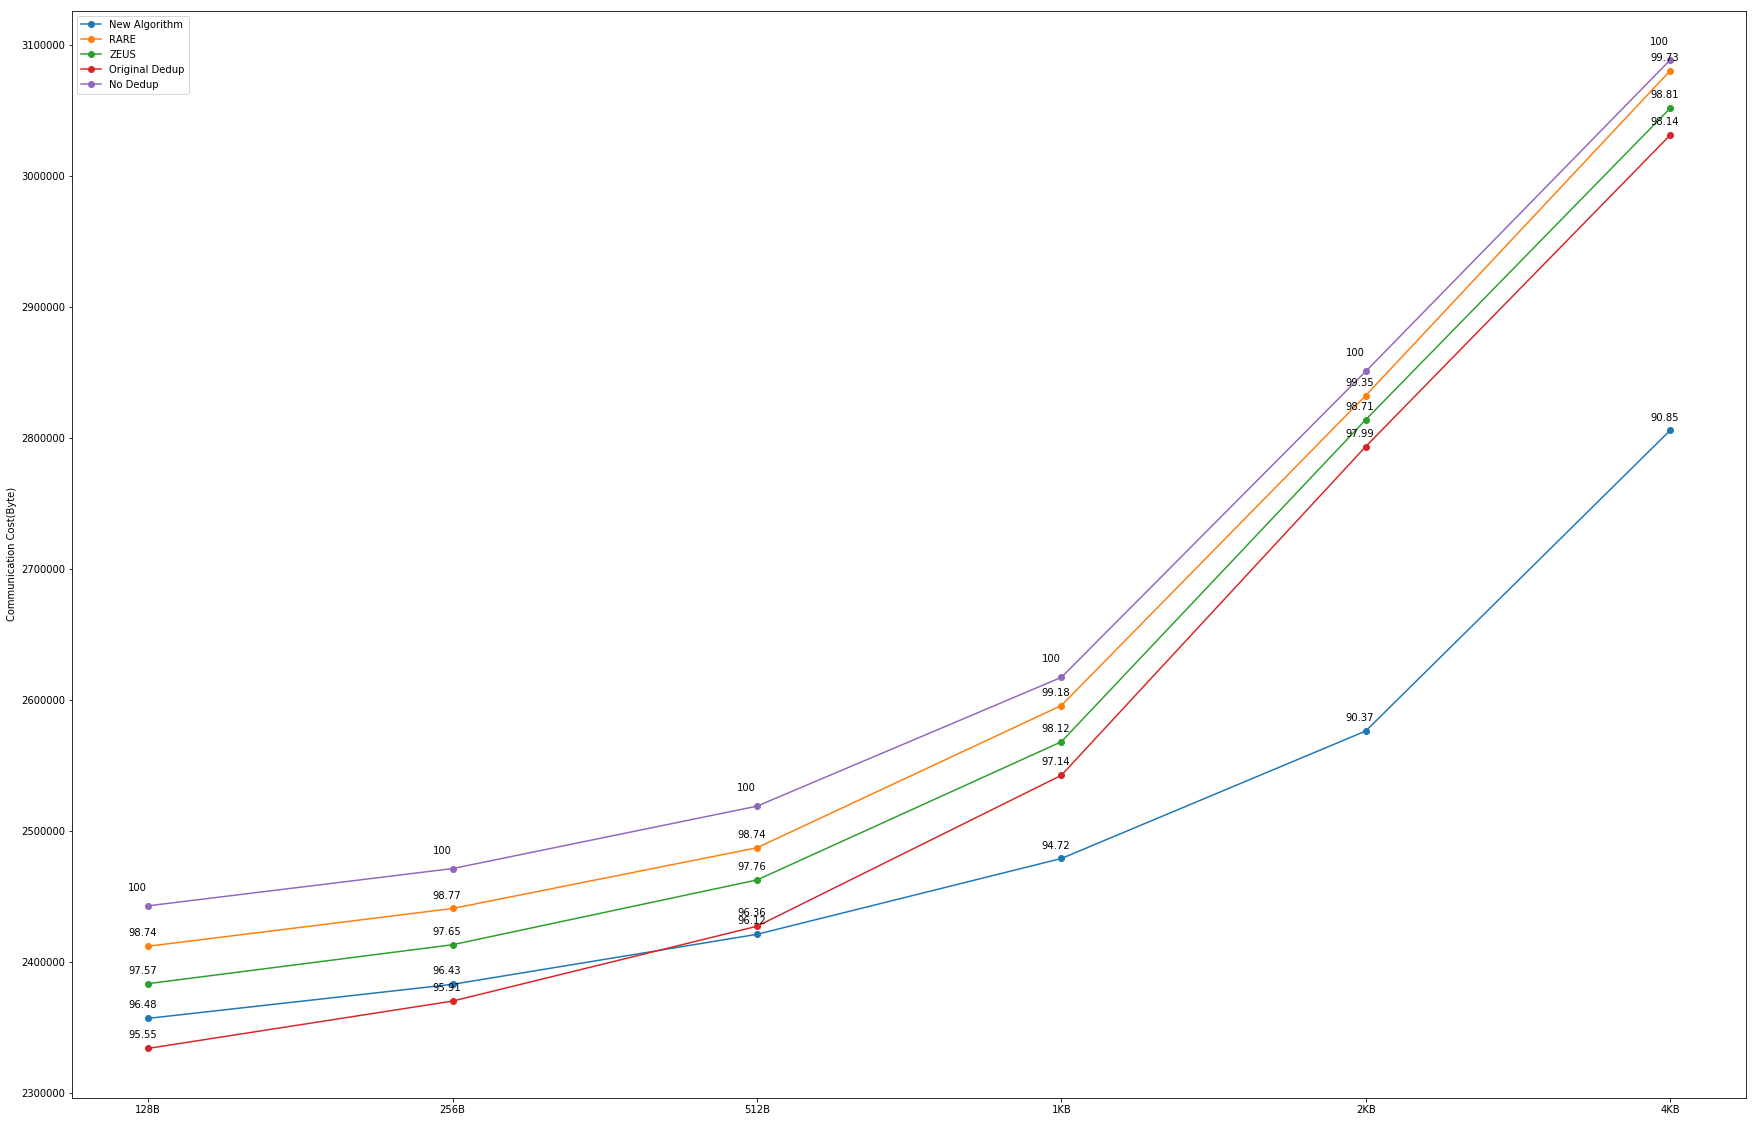

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (30, 20))
# plt.figure(dpi = 120)
xs = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(xs, new_byte, '-o', label = 'New Algorithm')
for x, y, z in zip(xs, new_upload_percentage, new_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, rare_byte, '-o', label = 'RARE')
for x, y, z in zip(xs, rare_upload_percentage, rare_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')

plt.plot(xs, zeus_byte, '-o', label = 'ZEUS')
for x, y, z in zip(xs, zeus_upload_percentage, zeus_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, dedup_byte, '-o', label = 'Original Dedup')
for x, y, z in zip(xs, dedup_upload_percentage, dedup_byte):
    plt.annotate("%.2f" % y, xy = (x,z), xytext=(-20, 10), textcoords='offset points')
    
plt.plot(xs, no_dedup_byte, '-o', label = 'No Dedup')
for x, y in zip(xs, no_dedup_byte):
    plt.annotate("100", xy = (x,y), xytext=(-20, 15), textcoords='offset points')
    
plt.legend()
plt.ylabel('Communication Cost(Byte)')
# plt.show()
plt.savefig('result.png')